<a href="https://colab.research.google.com/github/akiabe/coding-practice/blob/master/cats_vs_dogs_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Download example data
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip

--2020-06-19 01:01:58--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 2607:f8b0:4001:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   126MB/s    in 0.5s    

2020-06-19 01:01:58 (126 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
# Extract zip files
import os
import zipfile

# Files PATH
local_zip = '/tmp/cats_and_dogs_filtered.zip'

# Extract zipfiles
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [3]:
# Main path
base_dir = '/tmp/cats_and_dogs_filtered'

# train and valid files path
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')

# cats and dogs files path in train sets
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# cats and dogs files path in valid sets
valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')

In [4]:
# Print out file names in train sets
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)
print(train_cat_fnames[:5])
print(train_dog_fnames[:5])

['cat.642.jpg', 'cat.477.jpg', 'cat.468.jpg', 'cat.738.jpg', 'cat.501.jpg']
['dog.767.jpg', 'dog.471.jpg', 'dog.514.jpg', 'dog.309.jpg', 'dog.174.jpg']


In [5]:
# Print out the file numbers
print("train cats file number :", len(os.listdir(train_cats_dir)))
print("train dogs file number :", len(os.listdir(train_dogs_dir)))
print("valid cats file number :", len(os.listdir(valid_cats_dir)))
print("valid dogs file number :", len(os.listdir(valid_dogs_dir)))

train cats file number : 1000
train dogs file number : 1000
valid cats file number : 500
valid dogs file number : 500


In [6]:
import tensorflow as tf

In [7]:
# Define callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True
      
callbacks = myCallback()

In [8]:
from tensorflow.keras.preprocessing.image import  ImageDataGenerator

# Train images processing and data augmentation
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=.2,
    height_shift_range=.2,
    shear_range=.2,
    zoom_range=.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Flow train data in batches of 10 using train_generator 
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=10,
    class_mode='binary',
    target_size=(150, 150)
)

# valid images processing and data augmentation
valid_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=.2,
    height_shift_range=.2,
    shear_range=.2,
    zoom_range=.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Flow valid data in batches of 10 using valid_generator 
valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    batch_size=10,
    class_mode='binary',
    target_size=(150, 150)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
# Import the InceptionResNetV2 model  
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

# Create an instance of the inception resnet v2 model from pre-trained weights
pre_trained_model = InceptionResNetV2(input_shape=(150, 150, 3),
                                include_top=False,
                                weights='imagenet')

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False

219062272/219055592 [==============================] - 1s 0us/step


In [11]:
# Print the model summary
pre_trained_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
________________________________________________________________________________

In [15]:
last_layer = pre_trained_model.get_layer('block8_9_mixed')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 3, 3, 448)


In [20]:
# Build the model
from tensorflow.keras import layers
from tensorflow.keras import Model

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
#x = layers.Dropout(.2)(x)                  
x = layers.Dense(1, activation='sigmoid')(x)  

model = Model(pre_trained_model.input, x) 

In [21]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [22]:
# Optimizer
from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer=RMSprop(lr=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [23]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=200, # batch_size * steps_per_epoch = Images
    epochs=20,
    verbose=2,
    validation_data = valid_generator,
    validation_steps=100,
    callbacks=[callbacks]
)

Epoch 1/20
200/200 - 282s - loss: 0.1899 - accuracy: 0.9135 - val_loss: 0.1991 - val_accuracy: 0.9300
Epoch 2/20
200/200 - 279s - loss: 0.1744 - accuracy: 0.9250 - val_loss: 0.1954 - val_accuracy: 0.9250
Epoch 3/20
200/200 - 279s - loss: 0.1637 - accuracy: 0.9390 - val_loss: 0.2015 - val_accuracy: 0.9180
Epoch 4/20
200/200 - 287s - loss: 0.1479 - accuracy: 0.9445 - val_loss: 0.1763 - val_accuracy: 0.9400
Epoch 5/20
200/200 - 283s - loss: 0.1224 - accuracy: 0.9515 - val_loss: 0.1904 - val_accuracy: 0.9340
Epoch 6/20
200/200 - 287s - loss: 0.1410 - accuracy: 0.9465 - val_loss: 0.1299 - val_accuracy: 0.9530
Epoch 7/20
200/200 - 284s - loss: 0.1193 - accuracy: 0.9550 - val_loss: 0.2013 - val_accuracy: 0.9330
Epoch 8/20
200/200 - 287s - loss: 0.1300 - accuracy: 0.9575 - val_loss: 0.1824 - val_accuracy: 0.9350
Epoch 9/20
200/200 - 282s - loss: 0.1275 - accuracy: 0.9595 - val_loss: 0.1649 - val_accuracy: 0.9430
Epoch 10/20
200/200 - 288s - loss: 0.1078 - accuracy: 0.9625 - val_loss: 0.2122 - 

Text(0.5, 1.0, 'Training and validation loss')

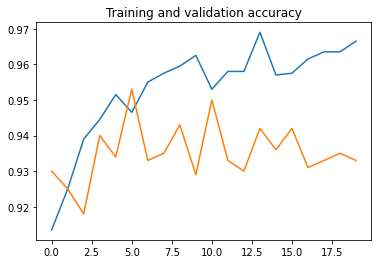

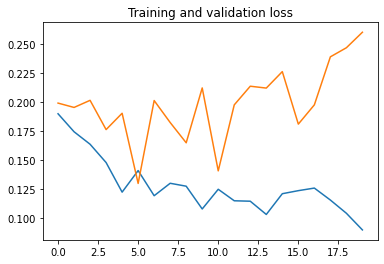

In [24]:
# Evaluating accuracy and loss for the model
import matplotlib.pyplot as plt

# Retrieve a list of list results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [ ]:
# Build the simple conv net
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(150, 150, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

In [ ]:
# Adam optimizer
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']   
)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=200, # batch_size * steps_per_epoch = Images
    epochs=20,
    verbose=2,
    validation_data = valid_generator,
    validation_steps=100,
    callbacks=[callbacks]
)

Epoch 1/20
200/200 - 27s - loss: 0.5639 - accuracy: 0.7050 - val_loss: 0.5841 - val_accuracy: 0.7040
Epoch 2/20
200/200 - 26s - loss: 0.5502 - accuracy: 0.7295 - val_loss: 0.5920 - val_accuracy: 0.6860
Epoch 3/20
200/200 - 26s - loss: 0.5499 - accuracy: 0.7270 - val_loss: 0.5700 - val_accuracy: 0.6990
Epoch 4/20
200/200 - 26s - loss: 0.5445 - accuracy: 0.7385 - val_loss: 0.5400 - val_accuracy: 0.7300
Epoch 5/20
200/200 - 26s - loss: 0.5329 - accuracy: 0.7395 - val_loss: 0.5655 - val_accuracy: 0.6920
Epoch 6/20
200/200 - 26s - loss: 0.5221 - accuracy: 0.7490 - val_loss: 0.6142 - val_accuracy: 0.6910
Epoch 7/20
200/200 - 26s - loss: 0.5181 - accuracy: 0.7500 - val_loss: 0.5434 - val_accuracy: 0.7230
Epoch 8/20
200/200 - 26s - loss: 0.5144 - accuracy: 0.7385 - val_loss: 0.5704 - val_accuracy: 0.7130
Epoch 9/20
200/200 - 26s - loss: 0.5155 - accuracy: 0.7565 - val_loss: 0.5192 - val_accuracy: 0.7350
Epoch 10/20
200/200 - 26s - loss: 0.5016 - accuracy: 0.7565 - val_loss: 0.5423 - val_accura

Text(0.5, 1.0, 'Training and validation loss')

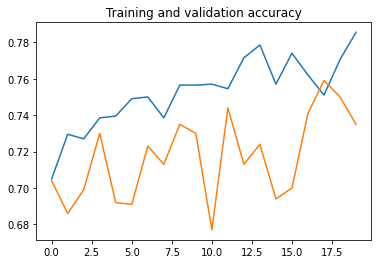

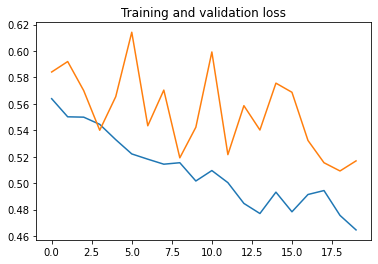

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) 

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [ ]:
# RMSprop optimizer
from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer=RMSprop(lr=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']   
)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=200,
    epochs=20,
    verbose=2,
    validation_data = valid_generator,
    validation_steps=100,
    callbacks=[callbacks]
)

Epoch 1/20
200/200 - 27s - loss: 0.4709 - accuracy: 0.7805 - val_loss: 0.5896 - val_accuracy: 0.7260
Epoch 2/20
200/200 - 27s - loss: 0.4836 - accuracy: 0.7865 - val_loss: 0.5088 - val_accuracy: 0.7420
Epoch 3/20
200/200 - 27s - loss: 0.4802 - accuracy: 0.7755 - val_loss: 0.5487 - val_accuracy: 0.7530
Epoch 4/20
200/200 - 27s - loss: 0.4828 - accuracy: 0.7870 - val_loss: 0.5284 - val_accuracy: 0.7560
Epoch 5/20
200/200 - 27s - loss: 0.4870 - accuracy: 0.7830 - val_loss: 0.5418 - val_accuracy: 0.7310
Epoch 6/20
200/200 - 27s - loss: 0.4652 - accuracy: 0.7925 - val_loss: 0.5606 - val_accuracy: 0.7250
Epoch 7/20
200/200 - 27s - loss: 0.4612 - accuracy: 0.7945 - val_loss: 0.6266 - val_accuracy: 0.7440
Epoch 8/20
200/200 - 27s - loss: 0.4823 - accuracy: 0.7785 - val_loss: 0.5184 - val_accuracy: 0.7500
Epoch 9/20
200/200 - 27s - loss: 0.4732 - accuracy: 0.7920 - val_loss: 0.5145 - val_accuracy: 0.7610
Epoch 10/20
200/200 - 27s - loss: 0.4793 - accuracy: 0.7825 - val_loss: 0.5385 - val_accura

Text(0.5, 1.0, 'Training and validation loss')

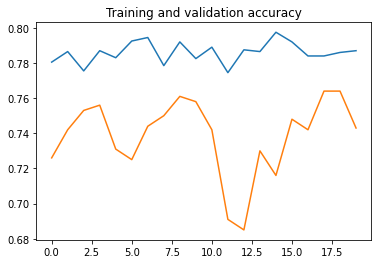

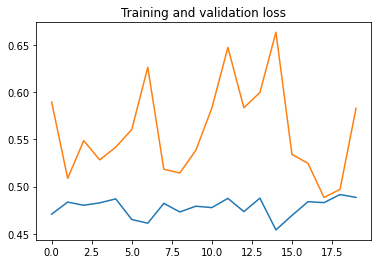

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [ ]:
# Running the model
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes[0])
  
  if classes[0]>0:
    print(fn + " is a dog")
    
  else:
    print(fn + " is a cat")